# Workgroup 4

Authors: Valerie Dube, Erzo Garay, Juan Marcos Guerrero y Matias Villalba

## Bootstraping

In [ ]:
install.packages("boot")

In [51]:
library(boot)

## Data base

The data is not created randomly; it is extracted from the "penn_jae.dat" database. This database is imported and filtered so that the variable "tg" becomes "t4," which is a dummy variable identifying those treated with t4 versus individuals in the control group.

In [ ]:
Penn <- as.data.frame(read.table("../../../data/penn_jae.dat", header=T ))
Penn<- subset(Penn, tg==4 | tg==0)
Penn$t4 <- ifelse(Penn$tg == 4, 1, Penn$tg)
Penn$tg <- NULL
attach(Penn)

## Bootstrap function

A function is created with the specified linear regression "log(inuidur1)~t4+ (female+black+othrace+factor(dep)+q2+q3+q4+q5+q6+agelt35+agegt54+durable+lusd+husd)," which outputs information about the estimated coefficients.


In [53]:
bootpar.fn <- function(data, index)
  coef(lm(log(inuidur1)~t4+ (female+black+othrace+factor(dep)+q2+q3+q4+q5+q6+agelt35+agegt54+durable+lusd+husd), data = data, subset = index))

In [82]:
reg_lineal = boot(Penn, bootpar.fn, 1000)

## Standard error

A table is created for the three specified variables: "t4", "female", and "black". Then, the distributions of the estimated parameters for the 1000 iterations are plotted.

In [93]:
original_values <- c(reg_lineal$t0[2], reg_lineal$t0[3], reg_lineal$t0[4])
standard_errors <- c(sd(reg_lineal$t[,2]),sd(reg_lineal$t[,3]), sd(reg_lineal$t[,4]))
table_data <- data.frame(
  "Original" = original_values,
  "Standard Error" = standard_errors
)
print(table_data)


          Original Standard.Error
t4     -0.07169248     0.03557456
female  0.12636833     0.03516956
black  -0.29376798     0.06033968


### t4 distribution

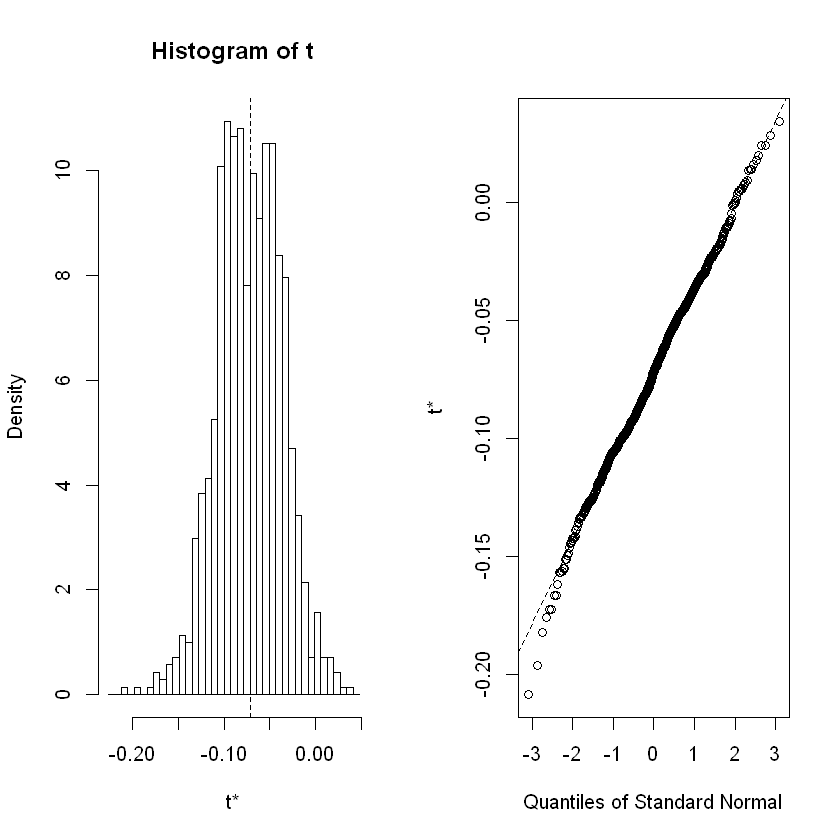

In [96]:
plot(reg_lineal, index=2) 

### Female distribution

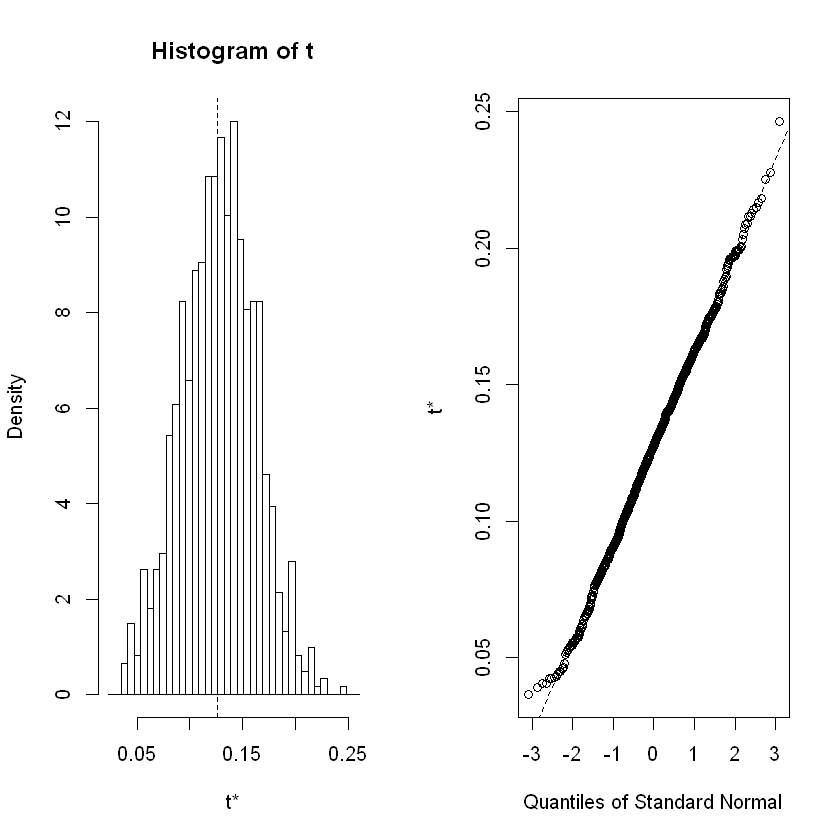

In [84]:
plot(reg_lineal, index=3) 

### Black distribution

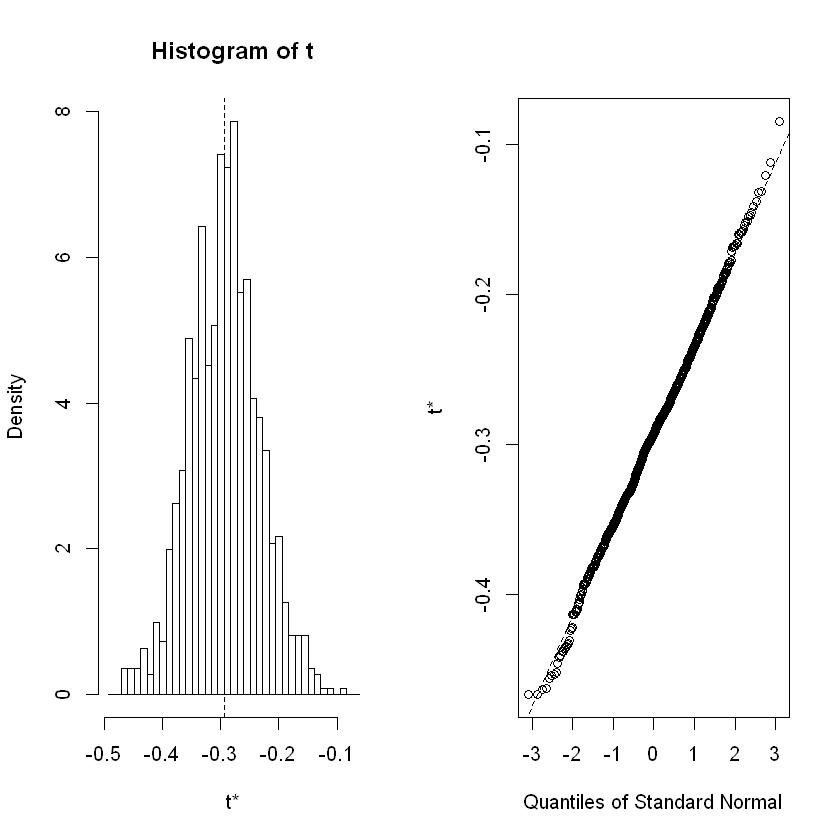

In [85]:
plot(reg_lineal, index=4) 

## Causal Forest